**Table of contents**<a id='toc0_'></a>    
1. [装饰器](#toc1_)    
1.1. [目的](#toc1_1_)    
1.2. [知识准备](#toc1_2_)    
1.2.1. [引用](#toc1_2_1_)    
1.2.2. [闭包](#toc1_2_2_)    
1.3. [引入装饰器](#toc1_3_)    
1.3.1. [问题](#toc1_3_1_)    
1.3.2. [尝试解决问题](#toc1_3_2_)    
1.3.2.1. [老大把工作交给 Low B](#toc1_3_2_1_)    
1.3.2.2. [老大把工作交给 Low BB](#toc1_3_2_2_)    
1.3.2.3. [老大把工作交给 Low BBB](#toc1_3_2_3_)    
1.4. [装饰器](#toc1_4_)    
1.4.1. [@xxx实现过程](#toc1_4_1_)    
1.4.2. [测试](#toc1_4_2_)    
1.4.3. [研究实现@的功能](#toc1_4_3_)    
1.4.4. [使用@对函数装饰的时间](#toc1_4_4_)    
1.4.5. [思考](#toc1_4_5_)    
1.5. [深入装饰器](#toc1_5_)    
1.5.1. [对无参数的函数进行装饰](#toc1_5_1_)    
1.5.2. [对有参数的函数进行装饰](#toc1_5_2_)    
1.5.3. [对带有不定长参数的函数进行装饰](#toc1_5_3_)    
1.5.4. [对带有return的函数进行装饰](#toc1_5_4_)    
1.5.5. [多个装饰器对同一个函数装饰](#toc1_5_5_)    
1.5.6. [装饰器带参数](#toc1_5_6_)    
1.5.7. [用类当做装饰器](#toc1_5_7_)    
1.5.7.1. [直接调用实例对象](#toc1_5_7_1_)    
1.5.7.2. [使用类对函数进行装饰](#toc1_5_7_2_)    
1.6. [总结](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[装饰器](#toc0_)

## 1.1. <a id='toc1_1_'></a>[目的](#toc0_)

看如下代码：

In [1]:
import time


def calculate_10w():
    """
    计算100000以内的每个数的立方和
    :return:
    """
    sum_ret = sum(i ** 3 for i in range(1, 100001))
    print("10w以内的每个数的立方和为：", sum_ret)


start_time = time.time()
calculate_10w()
stop_time = time.time()

print("耗费总时长为:", stop_time - start_time, "（秒）")


10w以内的每个数的立方和为： 25000500002500000000
耗费总时长为: 0.039019107818603516 （秒）


问题：
>**如果现在需要对5个函数都要进行耗时统计，请问怎样实现？难道将上图中的13、15、17行 写5遍吗？**

为了解决类似的问题，我们需要学习一个新的知识：装饰器

提醒：

>装饰器很重要，一定要学会

>装饰器是程序开发中经常会用到的一个功能，用好了装饰器，开发效率如虎添翼，所以这也是Python面试中必问的问题，但对于好多初次接触这个知识的人来讲，这个功能有点绕，自学时直接绕过去了，然后面试问到了就挂了，因为装饰器是程序开发的基础知识，这个都不会，别跟人家说你会Python, 看了下面的文章，保证你学会装饰器。


## 1.2. <a id='toc1_2_'></a>[知识准备](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[引用](#toc0_)
测试代码1（定义函数、调用函数、函数名是函数引用）

In [2]:
#### 第一波 ####
def foo():
    print('foo')
 
foo  # 表示是函数
foo()  # 表示调用foo函数


foo


测试代码2（多个函数用同一个函数名，会导致前面的定义的代码块不能被调用）

In [4]:
#### 第二波 ####
def foo(num):
    print(num)
 
foo = lambda x: x + 1
 
foo(1)  # 执行lambda表达式，而不再是原来的foo函数，因为foo这个名字被重新指向了另外一个匿名函数


2

函数名仅仅是个变量，只不过指向了定义的函数而已，所以才能通过**函数名()**调用，如果**函数名=xxx**被修改了，那么当在执行**函数名()**时，调用的就不是之前的那个函数了

### 1.2.2. <a id='toc1_2_2_'></a>[闭包](#toc0_)

In [5]:
def make_pencil(color):
    def write(content):
        print(f"正在使用({color})色，写：{content}")

    return write


black_pencil = make_pencil("黑")
black_pencil("我是喝墨水长大的")

red_pencil = make_pencil("红")
red_pencil("这么巧，我也是，只不过是红墨水")


正在使用(黑)色，写：我是喝墨水长大的
正在使用(红)色，写：这么巧，我也是，只不过是红墨水


小复习：
>闭包用到的核心其实就是：在一个函数中返回另外一个函数的引用，只不过这个被返回的函数中用到了其他函数中的变量而已。说到底就是 只要用一个变量指向某个函数代码块，就可以调用它

## 1.3. <a id='toc1_3_'></a>[引入装饰器](#toc0_)

### 1.3.1. <a id='toc1_3_1_'></a>[问题](#toc0_)

初创公司有N个业务部门，基础平台部门负责提供底层的功能，如：
- 数据库操作
- Redis调用
- 监控API等功能

其他业务部门使用基础功能时，只需调用基础平台提供的功能即可，如下：

In [8]:
############### 基础平台提供的功能如下 ###############
def f1():
    print('f1')
 
def f2():
    print('f2')
 
def f3():
    print('f3')
 
def f4():
    print('f4')
 
############### 业务部门A 调用基础平台提供的功能 ###############
f1()
f2()
f3()
f4()
 
############### 业务部门B 调用基础平台提供的功能 ###############
f1()
f2()
f3()
f4()


f1
f2
f3
f4
f1
f2
f3
f4


目前公司有条不紊的进行着，但是以前基础平台的开发人员在写代码时候没有关注验证权限相关的问题，

即：基础平台的提供的功能现在是可以被任何人使用。这种做法肯定是不妥的，因为这样会容易泄露功能代码

现在需要对基础平台的所有功能进行重构，为平台提供的所有功能添加验证机制，

即：执行功能前，先进行验证

想想，如果是你接手这个任务，你会怎么做呢？

### 1.3.2. <a id='toc1_3_2_'></a>[尝试解决问题](#toc0_)

#### 1.3.2.1. <a id='toc1_3_2_1_'></a>[老大把工作交给 Low B](#toc0_)
他是这么做的：

> 跟每个业务部门交涉，每个业务部门自己写代码，调用基础平台的功能之前先验证。哎！这样一来基础平台就不需要做任何修改了。太棒了，有充足的时间泡妹子...

当天Low B 被开除了…

#### 1.3.2.2. <a id='toc1_3_2_2_'></a>[老大把工作交给 Low BB](#toc0_)
他是这么做的：

In [9]:
############### 基础平台提供的功能如下 ############### 
def f1():
    # 验证1
    # 验证2
    # 验证3
    print('f1')
 
def f2():
    # 验证1
    # 验证2
    # 验证3
    print('f2')
 
def f3():
    # 验证1
    # 验证2
    # 验证3
    print('f3')
 
def f4():
    # 验证1
    # 验证2
    # 验证3
    print('f4')
 
### 业务部门A 调用基础平台提供的功能### 
f1()
f2()
f3()
f4()
 
### 业务部门B 调用基础平台提供的功能 ### 
 
f1()
f2()
f3()
f4()


f1
f2
f3
f4
f1
f2
f3
f4


过了一周 Low BB 被开除了…

#### 1.3.2.3. <a id='toc1_3_2_3_'></a>[老大把工作交给 Low BBB](#toc0_)
他是这么做的：
>只对基础平台的代码进行重构，其他业务部门无需做任何修改

In [11]:
############### 基础平台提供的功能如下 ############### 
def check_login():
    # 验证1
    # 验证2
    # 验证3
    pass
 
 
def f1():
    check_login()
    print('f1')
 
def f2():
    check_login()
    print('f2')
 
def f3():
    check_login()
    print('f3')
 
def f4():
    check_login()
    print('f4')


老大看了下Low BBB 的实现，嘴角漏出了一丝的欣慰的笑，语重心长的跟Low BBB聊了个天：

老大说：</br>
写代码要遵循开放封闭原则，虽然在这个原则是用的面向对象开发，但是也适用于函数式编程，简单来说，它规定已经实现的功能代码不允许被修改，但可以被扩展，即：

封闭：已实现的功能代码块</br>
开放：对扩展开发</br>
如果将开放封闭原则应用在上述需求中，那么就不允许在函数f1、f2、f3、f4的内部进行修改代码，老板就给了Low BBB一个实现方案：</br>

In [12]:
def check_login(func):
    def inner():
        # 验证1
        # 验证2
        # 验证3
        func()
    return inner
 
# 在f1、f2、f3、f4函数定义之前多写一句话
@check_login
def f1():
    print('f1')
@check_login
def f2():
    print('f2')
@check_login
def f3():
    print('f3')
@check_login
def f4():
    print('f4')


对于上述代码，也是仅仅对基础平台的代码进行修改，就可以实现在其他人调用函数f1、 f2、f3、f4 之前都进行权限验证操作，并且其他业务部门无需做任何操作。

Low BBB心惊胆战的问了下，这段代码的内部执行原理是什么呢？

老大正要生气，突然Low BBB的手机掉到地上，恰巧屏保就是Low BBB的女友照片，老大一看，喜笑颜开，决定和Low BBB交个好朋友，将他所知道的全部告诉他。

## 1.4. <a id='toc1_4_'></a>[装饰器](#toc0_)
单独以函数f1为例：

In [13]:
def check_login(func):
    def inner():
        # 验证1
        # 验证2
        # 验证3
        func()
    return inner
 
@check_login
def f1():
    print('f1')


当Python解释器对上述代码运行时，会从上到下解释代码，步骤如下：

1. 遇到def check_login(func):  将check_login函数加载到内存
2. 执行@check_login

没错， 从表面上看解释器仅仅会解释这两句代码，因为函数在 没有被调用之前其内部代码不会被执行。

从表面上看解释器着实会执行这两句，但是@check_login这一句代码里却有大文章， @xxx 是Python的一种语法糖（简单理解为令你很惊奇的功能）

### 1.4.1. <a id='toc1_4_1_'></a>[@xxx实现过程](#toc0_)
上例中@check_login内部会执行以下操作：

**步骤1：执行check_login函数**</br>
执行check_login函数 ，并将 @check_login 下面的函数作为check_login函数的参数

即：

In [ ]:
@check_login
def f1():

等价于如下代码

In [ ]:
check_login(f1)

所以，内部就会去执行：

In [ ]:
def inner(): 
    #验证 1
    #验证 2
    #验证 3
    f1()    # func是参数，此时 func 等于 f1 
return inner  # 返回的 inner，inner代表的是函数，非执行函数 ,其实就是将原来的 f1 函数塞进另外一个函数中


**步骤2：f1 = check_login的返回值**</br>
将执行完的check_login 函数返回值 赋值 给@check_login 下面的函数的函数名f1 即将check_login 的返回值再重新赋值给 f1，即：

In [ ]:
新f1 = inner

所以，以后业务部门想要执行f1函数时，就会执行新f1函数，在新f1函数内部先执行验证，再执行原来的f1函数，然后将原来f1 函数的返回值返回给了业务调用者

如此一来， 即执行了验证的功能，又执行了原来f1函数的内容，并将原f1函数返回值 返回给业务调用着

### 1.4.2. <a id='toc1_4_2_'></a>[测试](#toc0_)

In [15]:
def check_login(func):
    def inner():
        # 验证1
        if input("请输入用户名:") != "admin":
            return "用户名不正确"
        # 验证2
        if input("请输入密码:") != "123456":
            return "密码不正确"
        # 验证3
        if input("请输入手机短信验证码:") != "7788":
            return "验证码不正确"

        func()

    return inner


@check_login
def f1():
    print('f1')


f1()  # 调用f1函数

f1


### 1.4.3. <a id='toc1_4_3_'></a>[研究实现@的功能](#toc0_)

In [16]:
def check_login(func):
    def inner():
        # 验证1
        if input("请输入用户名:") != "admin":
            return "用户名不正确"
        # 验证2
        if input("请输入密码:") != "123456":
            return "密码不正确"
        # 验证3
        if input("请输入手机短信验证码:") != "7788":
            return "验证码不正确"

        func()

    return inner


# @check_login
def f1():
    print('f1')

# 下一行代码完成了第18行@check_login的作用
f1 = check_login(f1)

f1()  # 调用f1函数


f1


Low BBB 你明白了吗？要是没明白的话，我晚上去你家帮你实现吧！！！

### 1.4.4. <a id='toc1_4_4_'></a>[使用@对函数装饰的时间](#toc0_)

In [37]:
def timefun(func):
    print("----开始装饰----")
    def wrapped_func():
        print("----开始调用原函数----")
        func()
        print("----结束调用原函数----")

    print("----完成装饰----")
    return wrapped_func


@timefun
def helloworld():
    print("helloworld")

print("----")
helloworld()  # 注意此时并没有调用函数helloworld，如果运行结果中出现了一些信息，则说明@timefun开始装饰
              # 的时间是Python解释器在遇到那句代码时进行，而不是因为调用被装饰的函数 才开始装饰


----开始装饰----
----完成装饰----
----
----开始调用原函数----
helloworld
----结束调用原函数----


### 1.4.5. <a id='toc1_4_5_'></a>[思考](#toc0_)

其实实现装饰器用到了闭包，只是将闭包中外部函数的返回值 给了 被装饰函数名字，从而修改了函数指向而已

那么，有个问题需要想想：在使用普通闭包 与 将闭包用作实现装饰器 时，有什么不同吗？

闭包例子

In [22]:
def who(name):
    def do(content):
        print(f"({name}):{content}")

    return do


zhangsan = who("张三")
lisi = who("李四")

zhangsan("你努力了吗？")
lisi("为啥努力！")
zhangsan("你确定不要努力吗？")
lisi("嗯，确定？")
zhangsan("那可就不要要怪别人努力了啊")
lisi("别人与我何关!")
zhangsan("隔壁那户人家姓xxxx")
lisi("( ⊙ o ⊙ )啊！")


(张三):你努力了吗？
(李四):为啥努力！
(张三):你确定不要努力吗？
(李四):嗯，确定？
(张三):那可就不要要怪别人努力了啊
(李四):别人与我何关!
(张三):隔壁那户人家姓xxxx
(李四):( ⊙ o ⊙ )啊！


装饰器例子

In [23]:
def log(func):
    def call():
        ret = func()
        if ret and isinstance(ret , str):
            with open("log.txt", "w") as f:
                f.write(ret)

        return ret
    return call

@log
def print_hello():
    return "hello world"

print(print_hello())


hello world


小总结：

- 普通闭包：内部函数将使用的外部变量当做数据来用

- 将闭包当做装饰器：内部函数将使用的外部变量当做可调用的对象(例如函数)来调用

- 装饰器(decorator)功能
    - 引入日志
    - 函数执行时间统计
    - 执行函数前预备处理
    - 执行函数后清理功能
    - 权限校验等场景
    - 缓存

## 1.5. <a id='toc1_5_'></a>[深入装饰器](#toc0_)

### 1.5.1. <a id='toc1_5_1_'></a>[对无参数的函数进行装饰](#toc0_)


In [24]:
from time import ctime, sleep

# 定义一个闭包
def timefun(func):
    def wrapped_func():
        print(f"{func.__name__} called at {ctime()}")
        func()

    return wrapped_func


@timefun  # 使用装饰器对foo进行装饰，此时相当于foo = timefun(foo)
def foo():
    print("I am foo")

foo()  # 相当于调用的是wrapped_func函数
sleep(2)
foo()  # 相当于调用的是wrapped_func函数


foo called at Thu Dec 29 18:14:15 2022
I am foo
foo called at Thu Dec 29 18:14:17 2022
I am foo


上面代码理解装饰器执行行为可理解成

1. foo = timefun(foo)
    1. foo先作为参数赋值给func后，foo接收指向timefun返回的wrapped_func
2. 执行foo()
    1. 调用foo()即等价调用wrapped_func()
    2. 内部函数wrapped_func被引用，所以外部函数的func变量(自由变量)并没有释放
    3. func里保存的是原foo函数对象

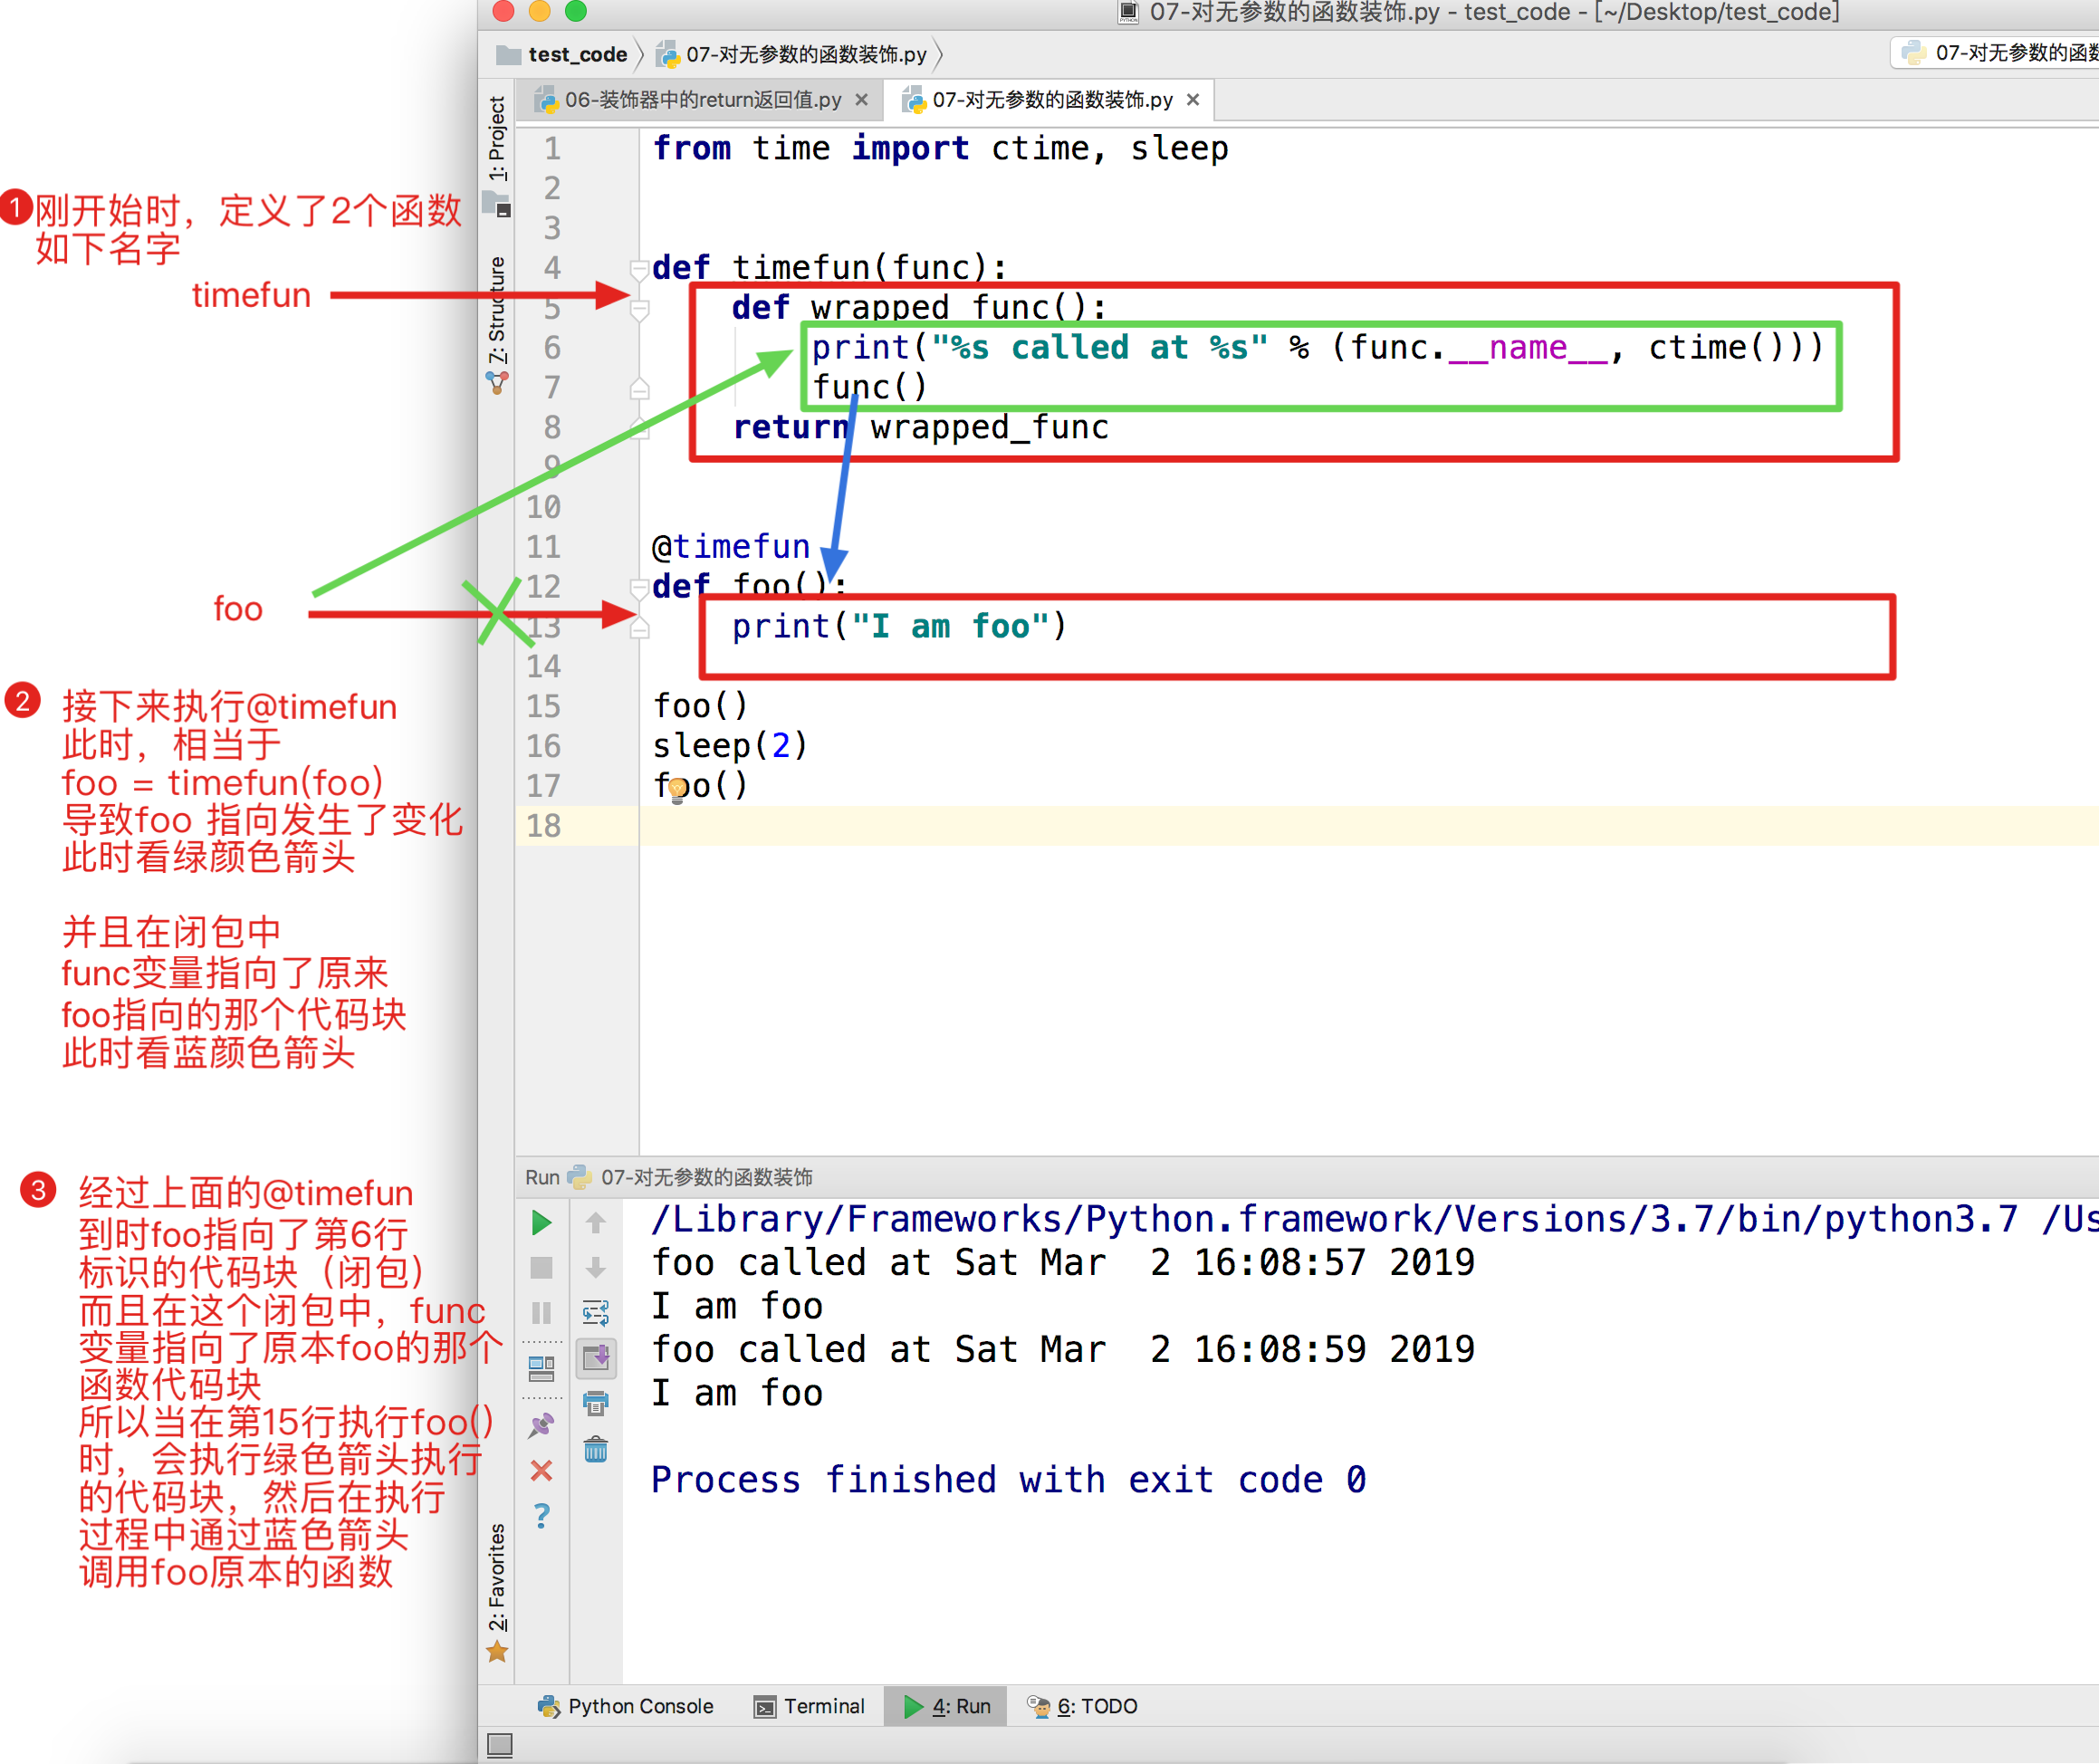

### 1.5.2. <a id='toc1_5_2_'></a>[对有参数的函数进行装饰](#toc0_)

In [25]:
from time import ctime, sleep

def timefun(func):
    def wrapped_func(a, b):
        print(f"{func.__name__} called at {ctime()}")
        print(a, b)
        func(a, b)

    return wrapped_func

@timefun
def foo(a, b):
    print(a+b)

foo(3,5)
sleep(2)
foo(2,4)


foo called at Thu Dec 29 18:22:12 2022
3 5
8
foo called at Thu Dec 29 18:22:14 2022
2 4
6


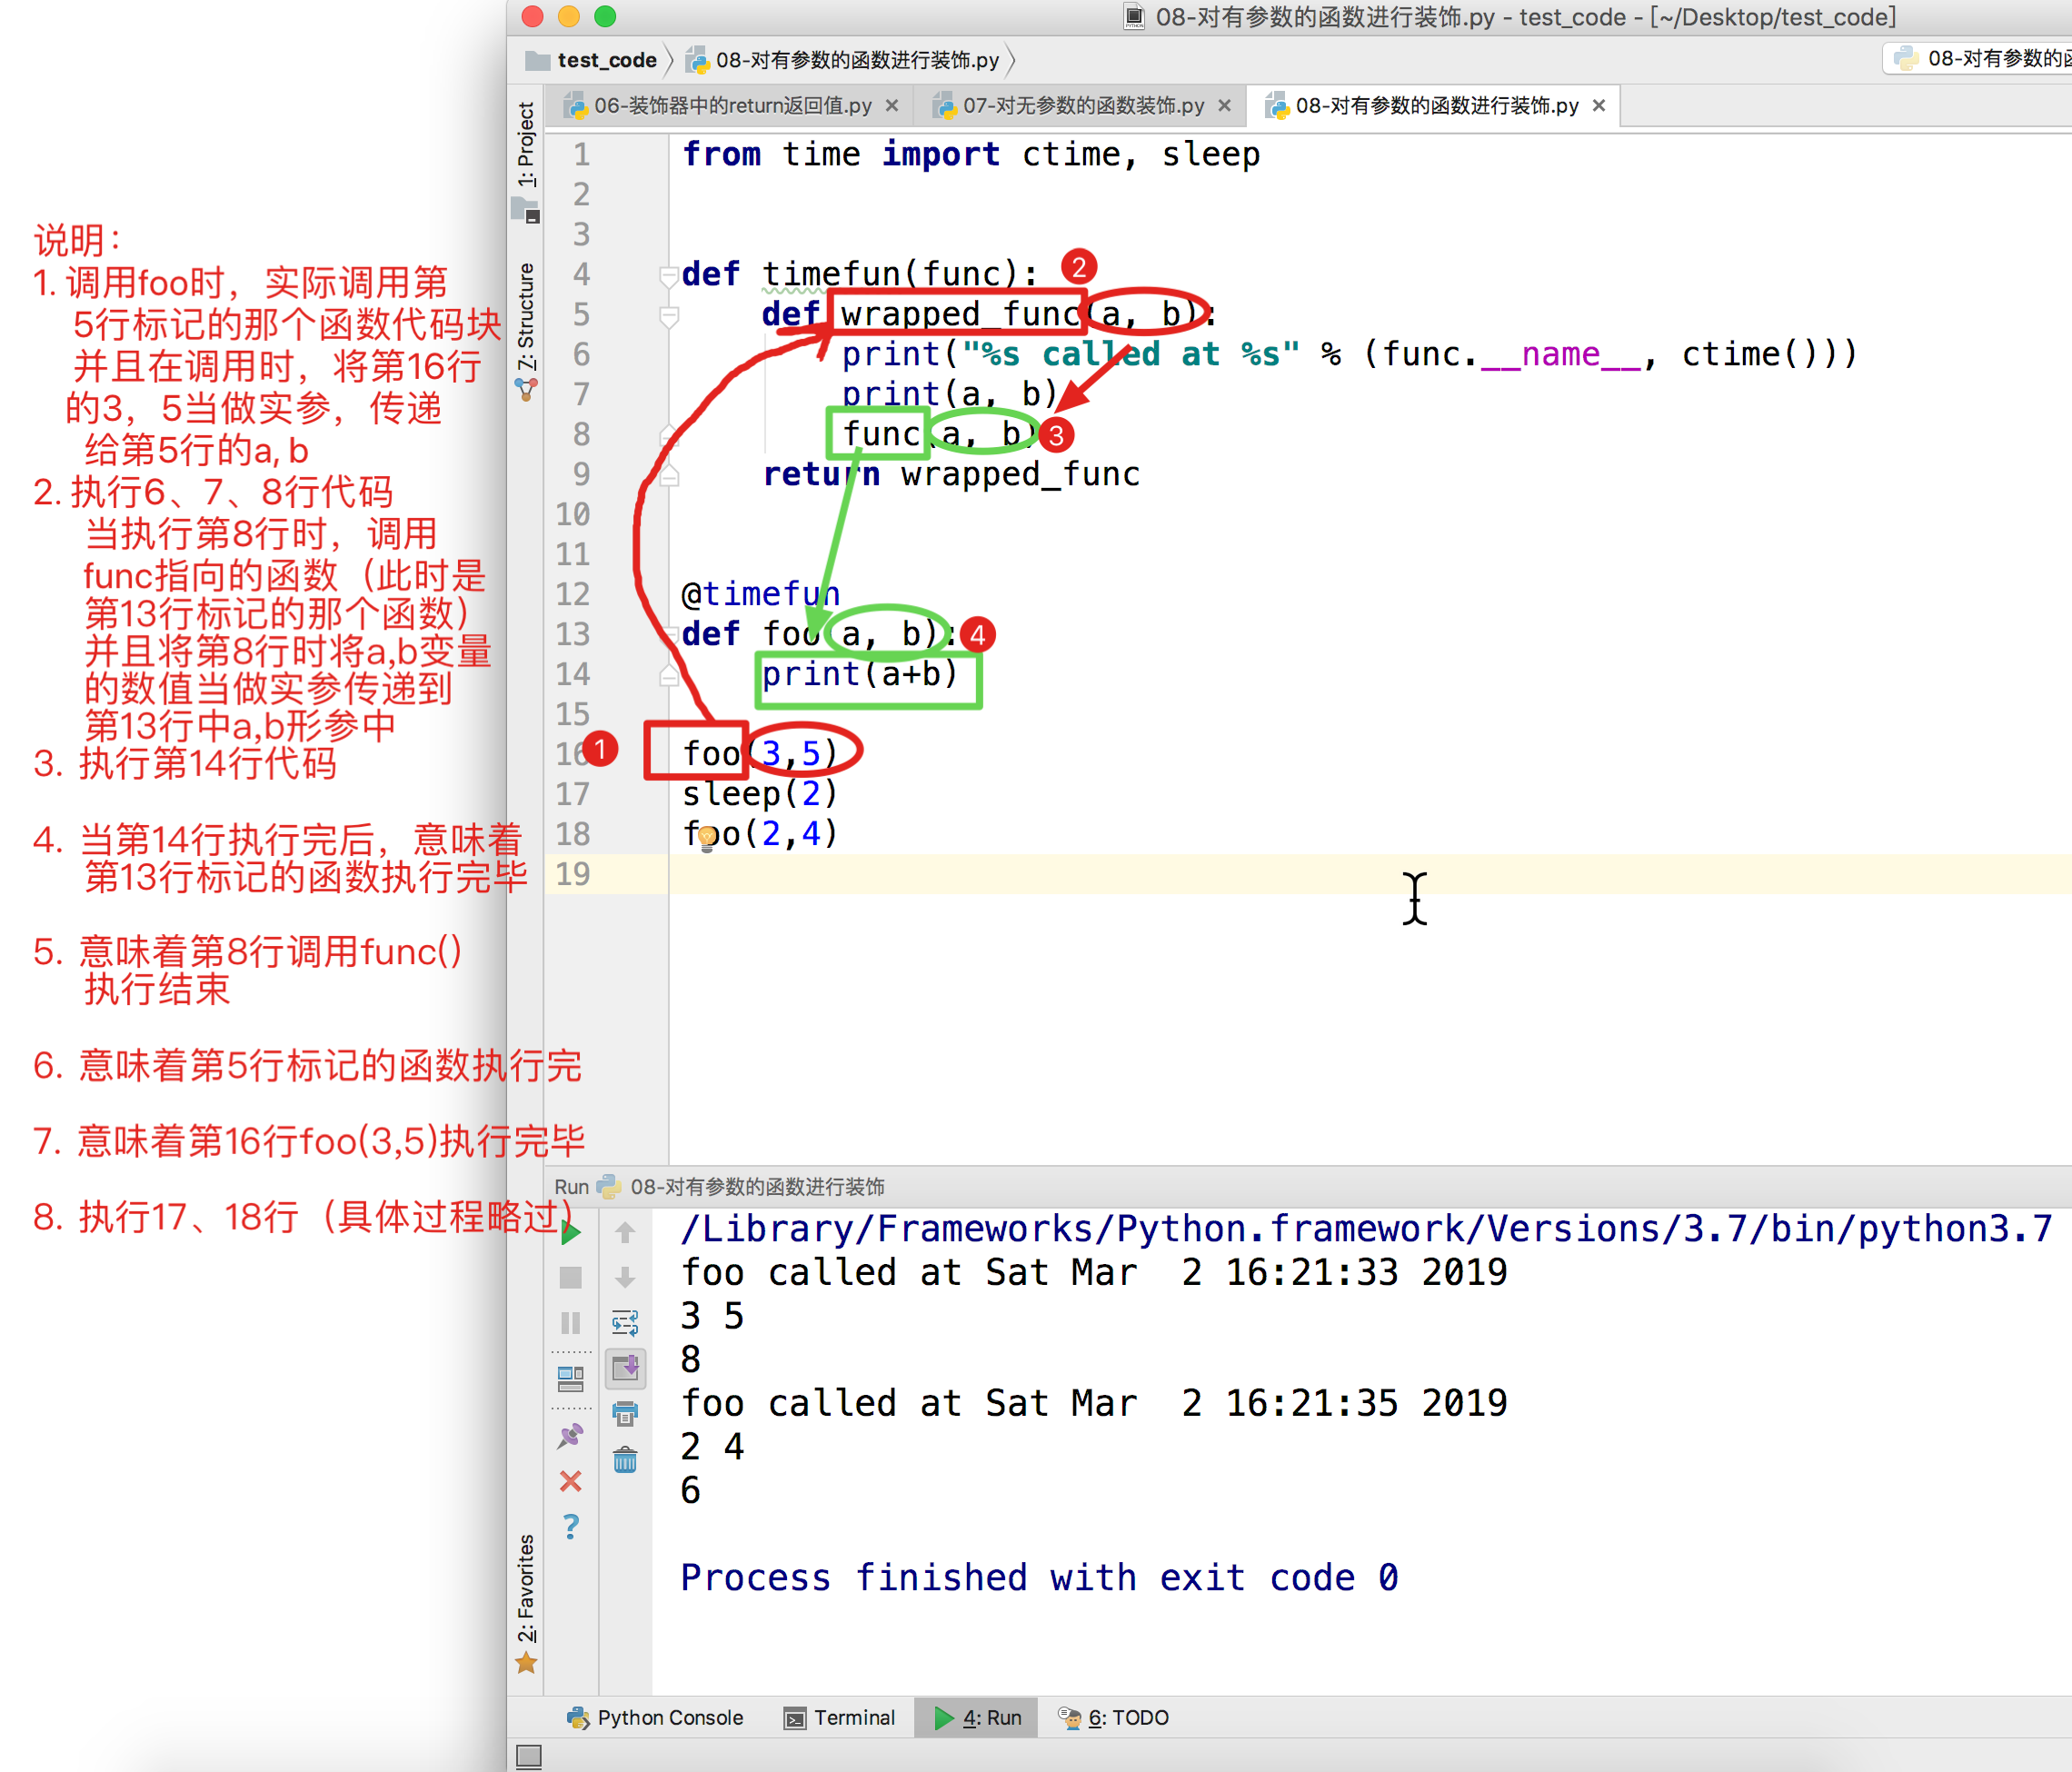

### 1.5.3. <a id='toc1_5_3_'></a>[对带有不定长参数的函数进行装饰](#toc0_)

In [45]:
from time import ctime, sleep
import functools


def timefun(func):
    @functools.wraps(func) #* 使用内置的装饰器 @functools.wraps，它会帮助保留原函数的元信息（也就是将原函数的信息拷贝到对应的装饰器函数里）
    def wrapped_func(*args, **kwargs):
        # args=(3,5,7)
        # kwargs = {}
        print(f"{func.__name__} called at {ctime()}")
        func(*args, **kwargs)  # 对args,kwargs进行拆包，此时相当于func(3,5,7)

    return wrapped_func


@timefun
def foo(a, b, c):
    # a=3,b=5,c=7
    print(a+b+c)  # 15

foo(3,5,7)  # 将3，5，7这些未命名参数传递到第5行函数中，此时args用元组存储
print(foo.__name__) #! 如果不使用@functools.wraps(func) --> wrapped_func 


foo called at Thu Dec 29 19:00:00 2022
15
foo


### 1.5.4. <a id='toc1_5_4_'></a>[对带有return的函数进行装饰](#toc0_)

In [27]:
from time import ctime, sleep


def timefun(func):
    def wrapped_func():
        print(f"{func.__name__} called at {ctime()}")
        func()

    return wrapped_func


@timefun
def foo():
    print("I am foo")


@timefun
def get_info():
    return '----hahah---'

foo()
sleep(2)
foo()

print(get_info())  #! 可以看到这里并没有 get_info这个函数 返回的数据，因此这里有不完善的地方


foo called at Thu Dec 29 18:27:35 2022
I am foo
foo called at Thu Dec 29 18:27:37 2022
I am foo
get_info called at Thu Dec 29 18:27:37 2022
None


如果修改装饰器为return func()，完整代码如下：

In [28]:
from time import ctime, sleep


def timefun(func):
    def wrapped_func():
        print(f"{func.__name__} called at {ctime()}")
        # 这里应该加上return ，及时func指向的函数没有返回值，那么默认也是None，
        # 此时无非是return None而已，也是可以的
        return func()

    return wrapped_func


@timefun
def foo():
    print("I am foo")


@timefun
def get_info():
    return '----hahah---'

foo()
sleep(2)
foo()

print(get_info())


foo called at Thu Dec 29 18:28:43 2022
I am foo
foo called at Thu Dec 29 18:28:45 2022
I am foo
get_info called at Thu Dec 29 18:28:45 2022
----hahah---


小总结：

一般情况下为了让装饰器更通用，可以有return，即使这个被装饰的函数默认没有返回值也不会有问题，因为此时相当于return None

### 1.5.5. <a id='toc1_5_5_'></a>[多个装饰器对同一个函数装饰](#toc0_)

In [36]:
# 定义函数：完成包裹数据
def makeBold(fn):
    def wrapped():
        return f"<b>{fn()}</b>"

    return wrapped

# 定义函数：完成包裹数据
def makeItalic(fn):
    def wrapped():
        return f"<i>{fn()}</i>"

    return wrapped

@makeBold
def test1():
    return "hello world-1"

@makeItalic
def test2():
    return "hello world-2"

@makeBold
@makeItalic
def test3():
    return "hello world-3"

print(test1())
print(test2())
print(test3())


<b>hello world-1</b>
<i>hello world-2</i>
<b><i>hello world-3</i></b>


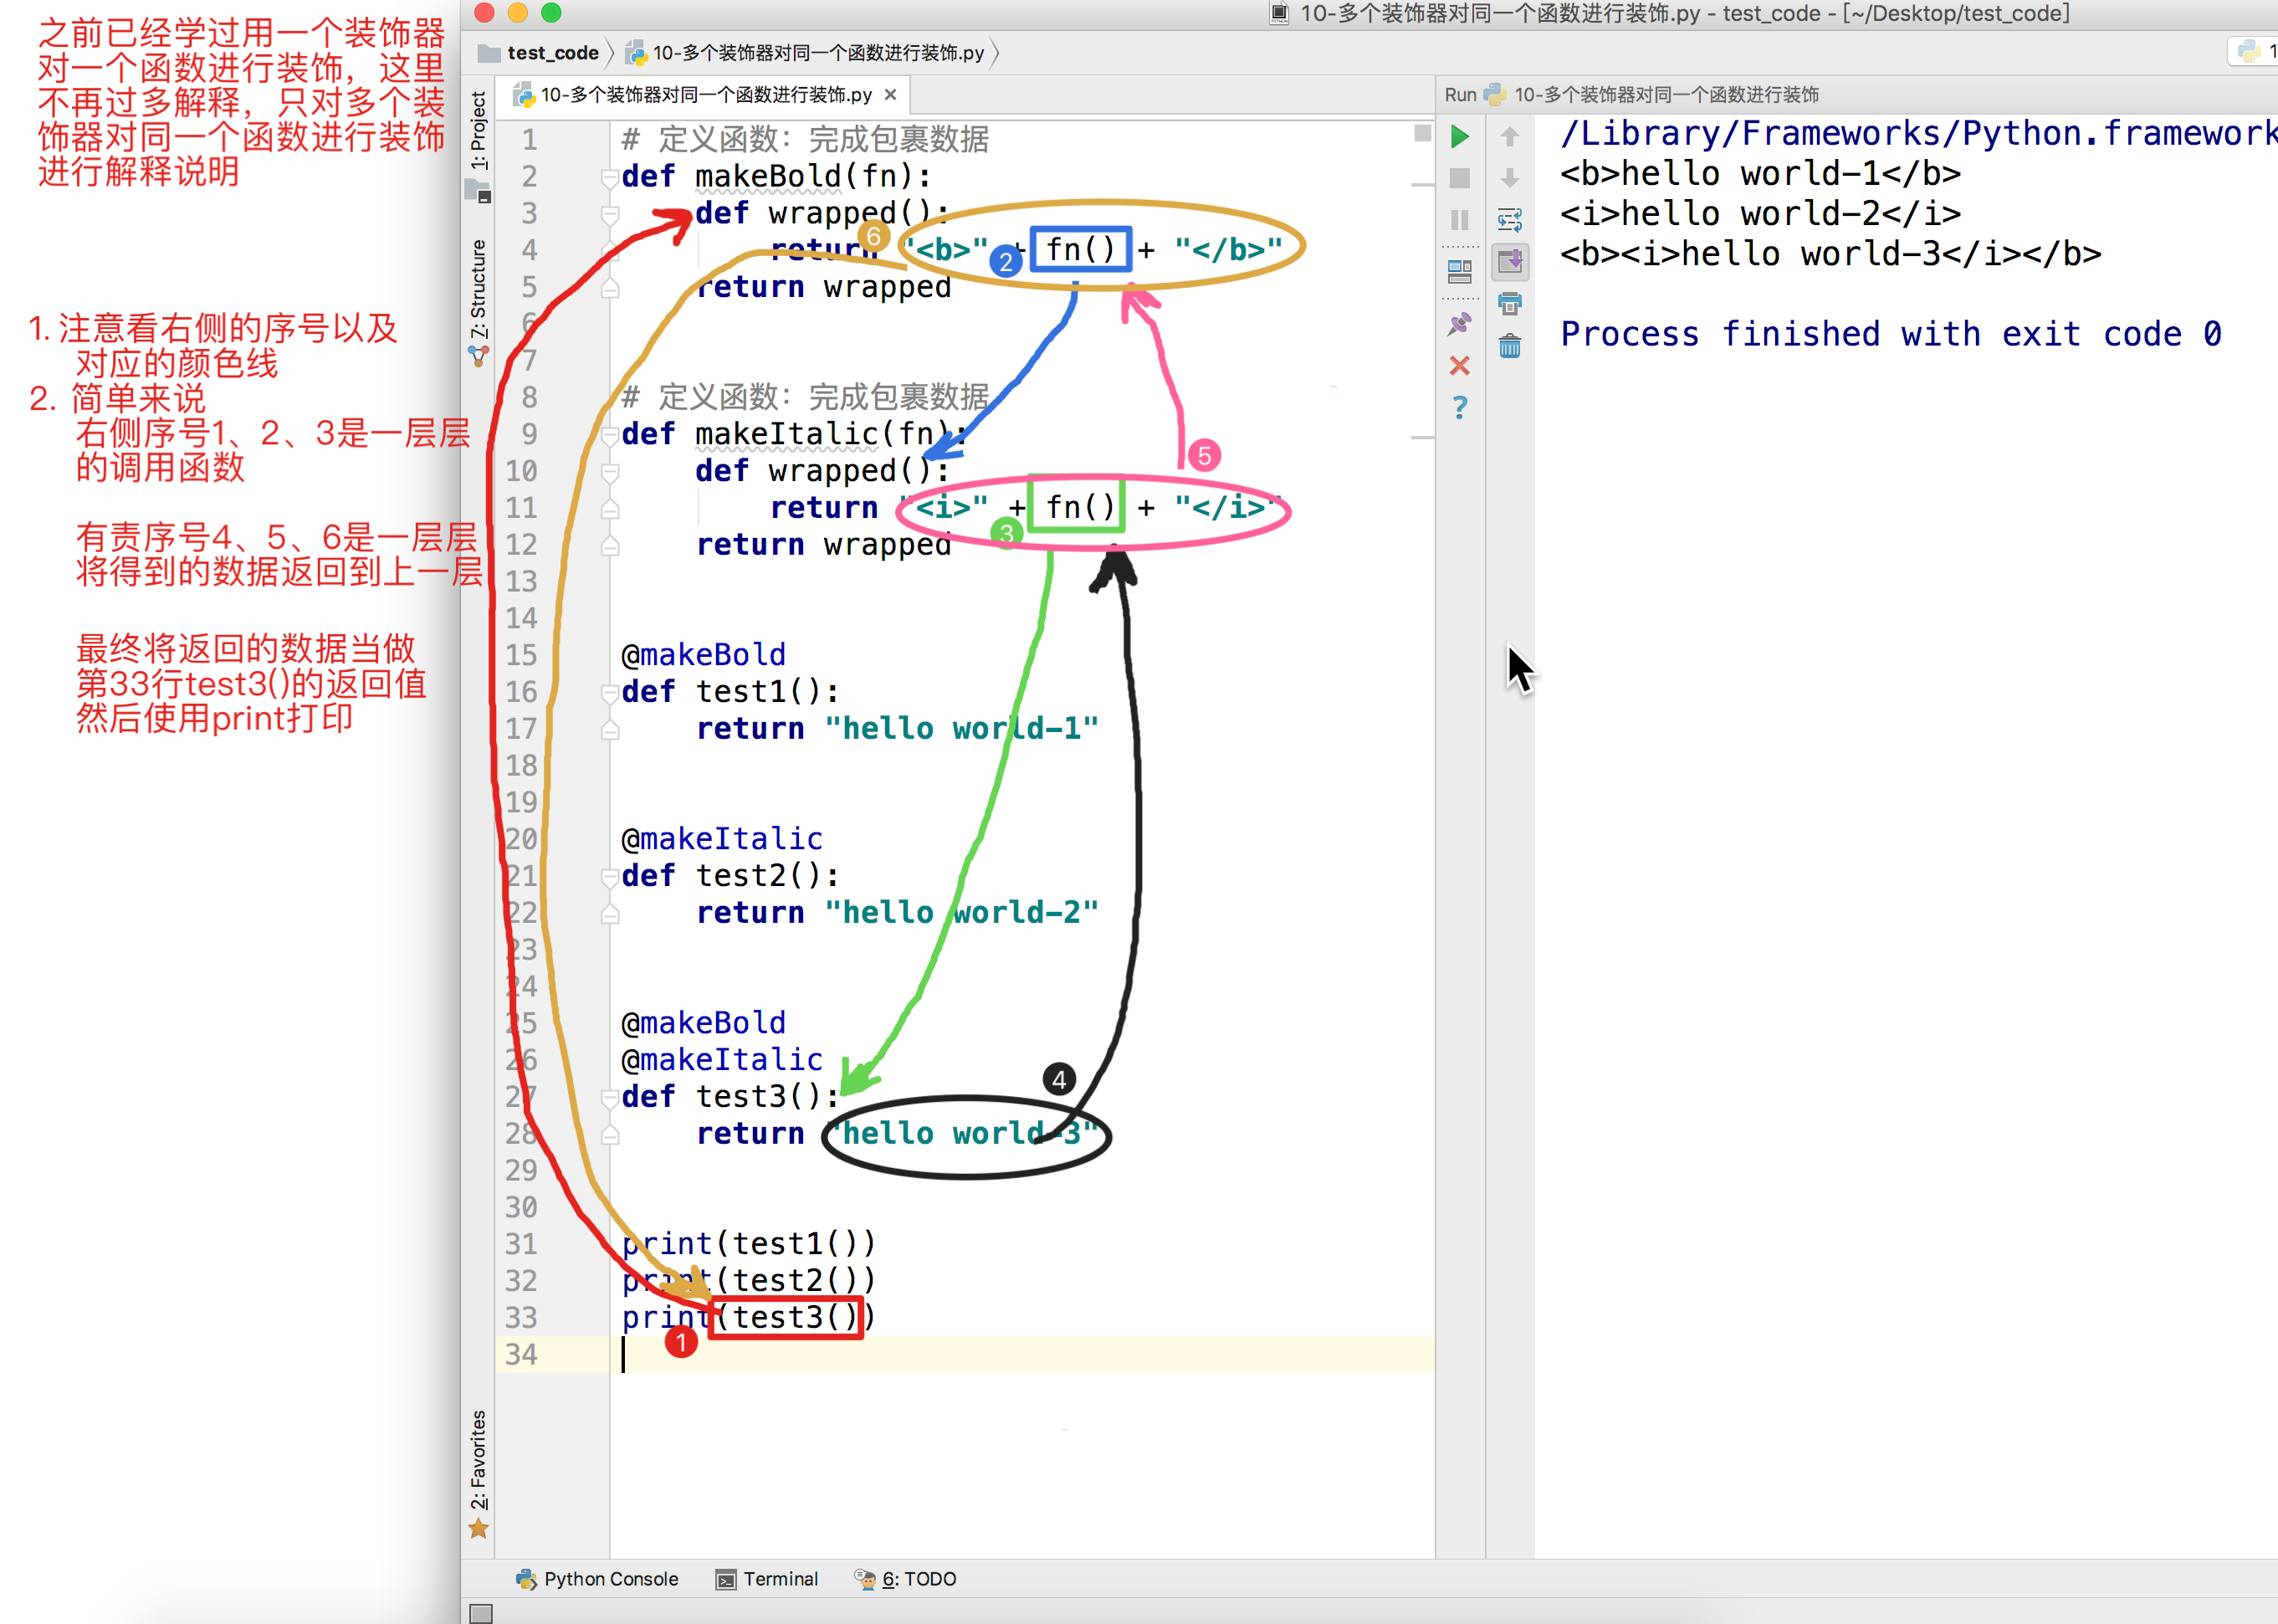

### 1.5.6. <a id='toc1_5_6_'></a>[装饰器带参数](#toc0_)

在原有装饰器的基础上，设置外部变量

In [38]:
import time


def call_out2(timeout=0):
    def call_out1(func):
        def call():
            print("----1----")
            time.sleep(timeout)
            ret = func()
            print("----2----")
            return ret
        return call
    return call_out1


# 下面的装饰过程
# 1. 调用timefun_arg("itcast") 得到一个返回值，即time_fun
# 3. 然后执行time_fun(foo) 得到一个返回值，即wrapped_func
# 4. 让foo = wrapped_fun，即foo现在指向wrapped_func
@call_out2(2)
def print_hello():
    print("hello world")
    return "ok"


print(print_hello())


----1----
hello world
----2----
ok


可以理解为
1. 修改print_hello的指向
print_hello = call_out2(2)(print_hello)
2. 调用print_hello指向的新的函数
print_hello()

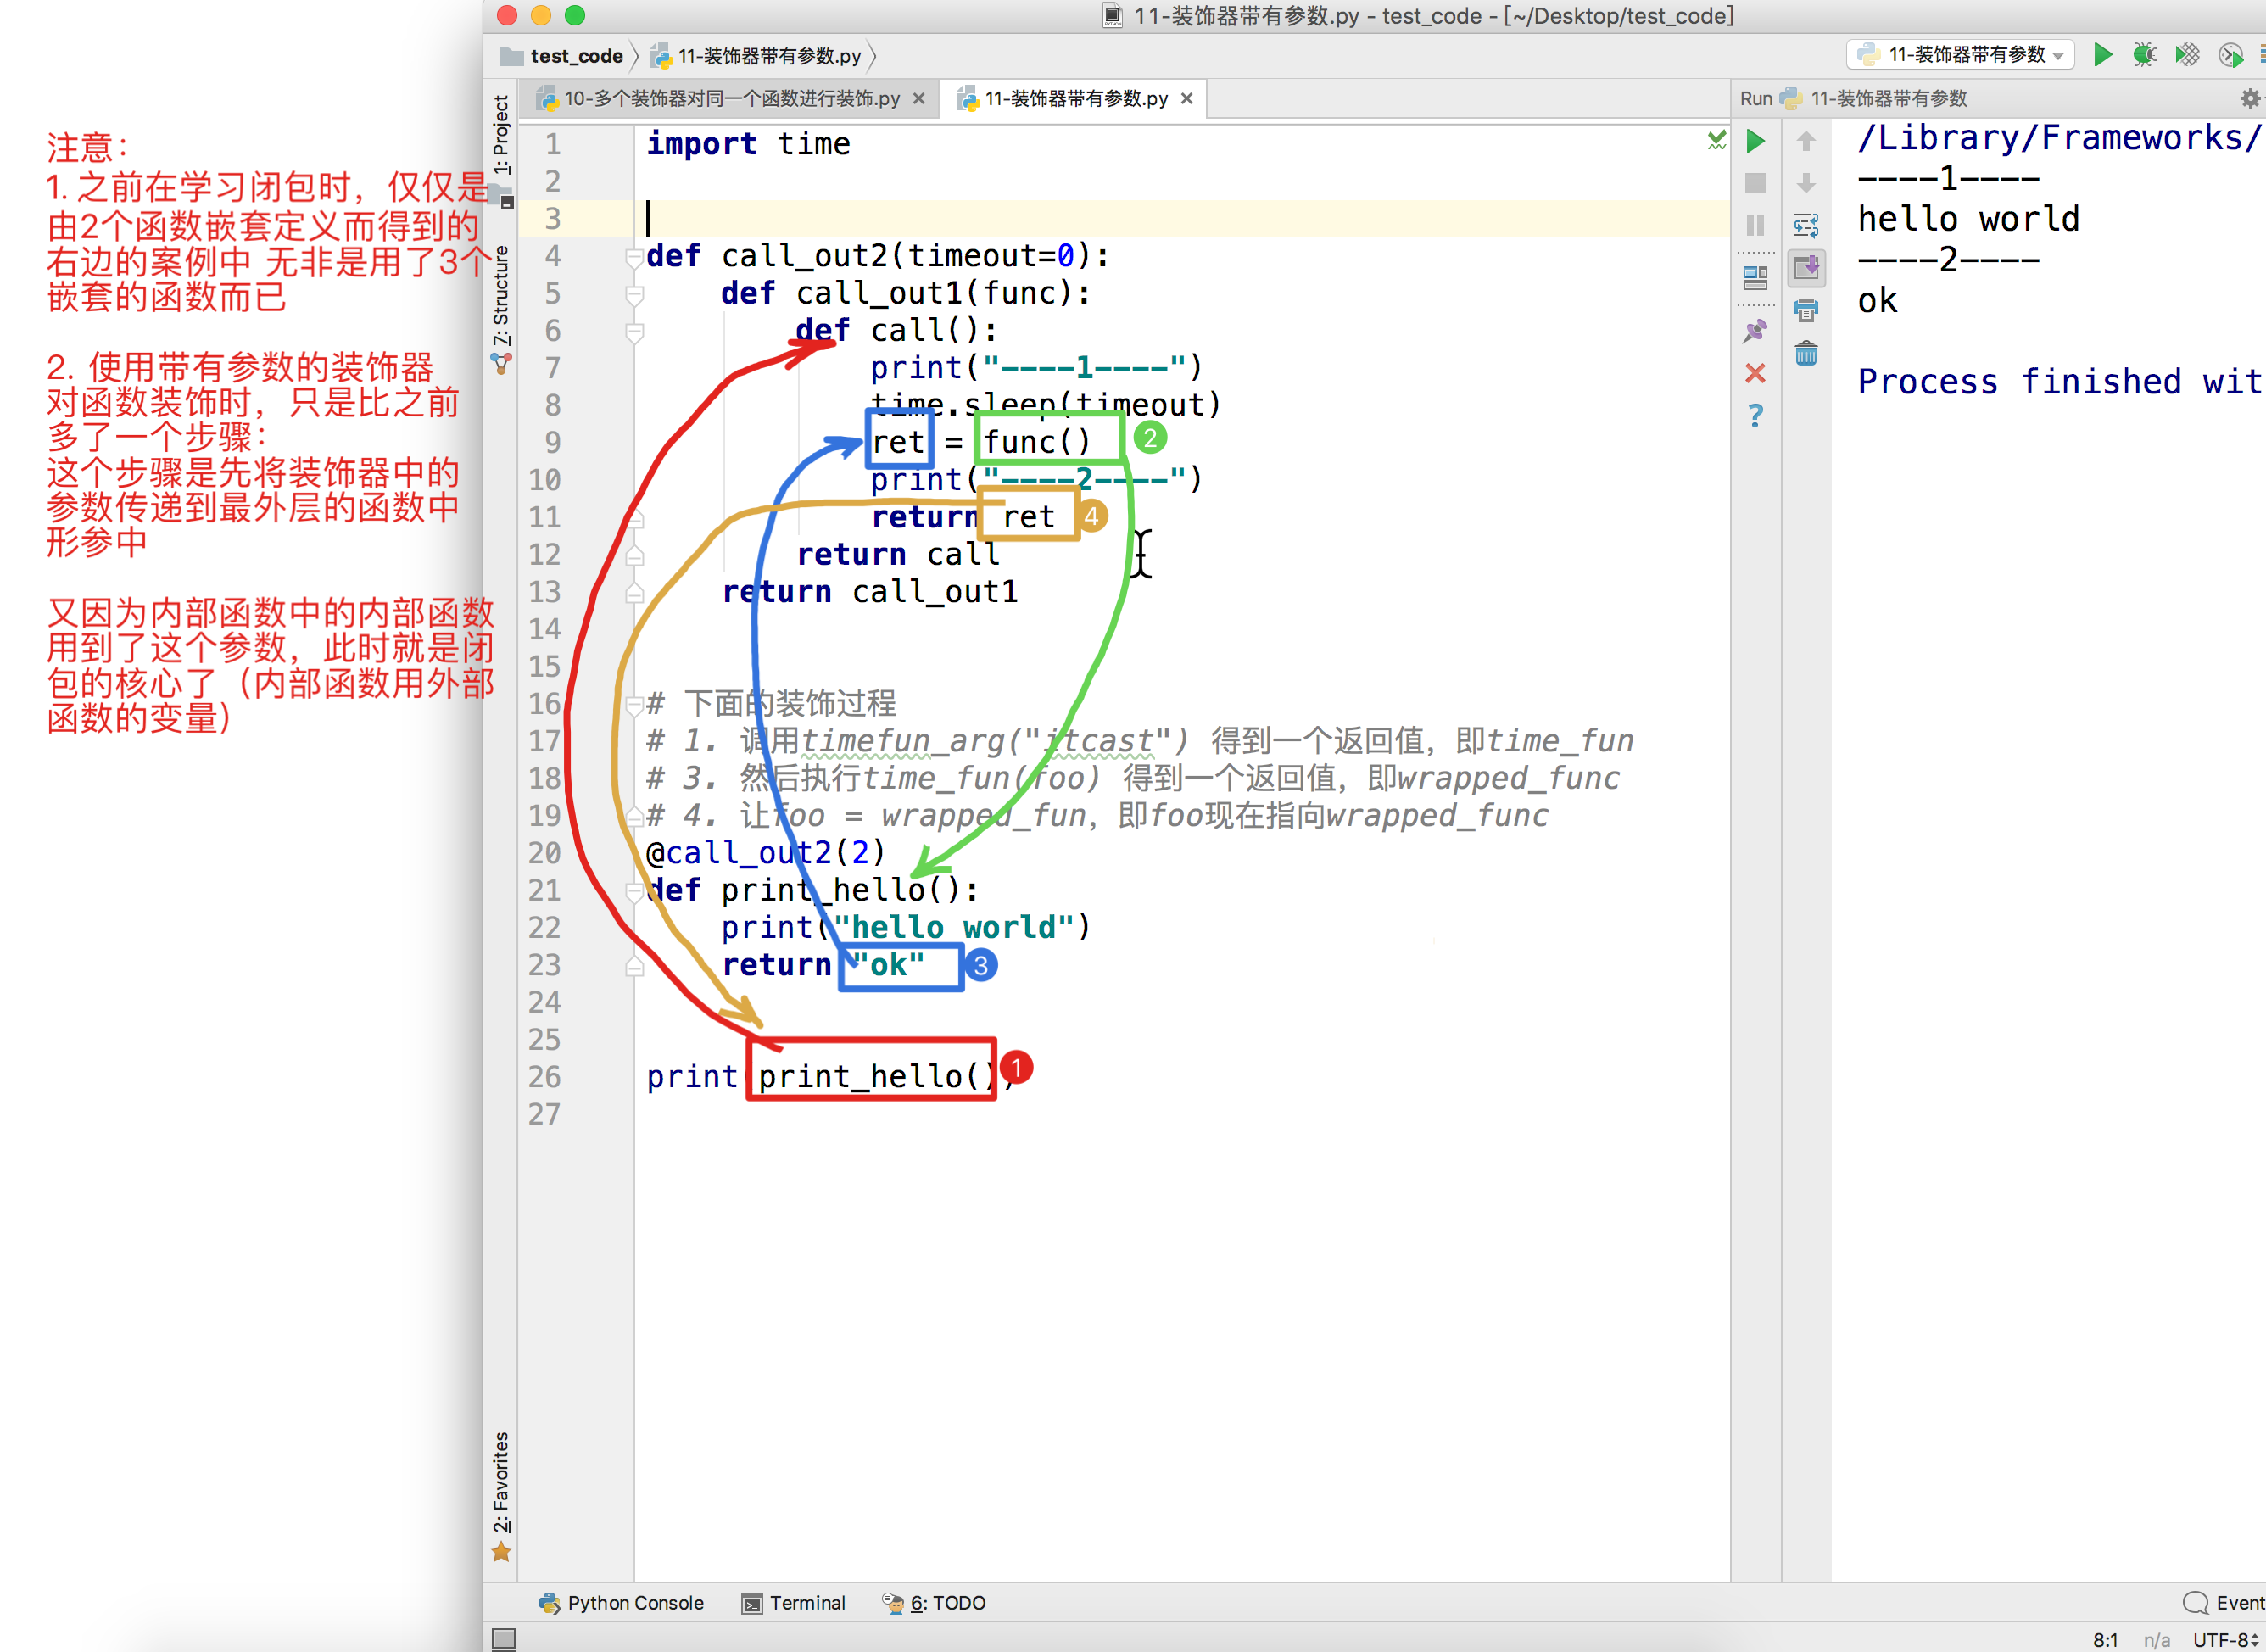

### 1.5.7. <a id='toc1_5_7_'></a>[用类当做装饰器](#toc0_)

装饰器函数其实是这样一个接口约束，它必须接受一个callable对象作为参数，然后返回一个callable对象。在Python中一般callable对象都是函数，但也有例外。只要某个对象重写了 __call__() 方法，那么这个对象就是callable的。

#### 1.5.7.1. <a id='toc1_5_7_1_'></a>[直接调用实例对象](#toc0_)

In [39]:
class Test():
    def __call__(self):
        print('call me!')

t = Test()
t()  # 因为创建t的类Test中实现了__call__方法，那么也就意味着可以直接调用这个实例对象

call me!


#### 1.5.7.2. <a id='toc1_5_7_2_'></a>[使用类对函数进行装饰](#toc0_)

In [41]:
class Test(object):
    def __init__(self, func):
        print("---初始化---")
        print(f"func name is {func.__name__}")
        self.__func = func
    def __call__(self):
        print("---装饰器中的功能---")
        self.__func()


#说明：
#1. 当用Test来装作装饰器对test函数进行装饰的时候，首先会创建Test的实例对象
#   并且会把test这个函数名当做参数传递到__init__方法中
#   即在__init__方法中的属性__func指向了test指向的函数
#2. test指向了用Test创建出来的实例对象
#3. 当在使用test()进行调用时，就相当于直接调用实例对象，因此会调用这个对象的__call__方法
#4. 为了能够在__call__方法中调用原来test指向的函数体，所以在__init__方法中就需要一个实例属性来保存这个函数体的引用
#   所以才有了self.__func = func这句代码，从而在调用__call__方法中能够调用到test之前的函数体
@Test
def test():
    print("----test---")


test()  # 如果把这句话注释，重新运行程序，依然会看到"--初始化--"


---初始化---
func name is test
---装饰器中的功能---
----test---


## 1.6. <a id='toc1_6_'></a>[总结](#toc0_)
1. 装饰器：能够快速将函数的指向修改，能够在不修改代码的前提下，给函数添加功能的方式
2. 装饰器功能：给函数添加功能
3. 特点：不修改原函数代码，还能添加功能；只能在原函数运行之前或者之后添加，不能在原函数运行一半时添加
4. 实现过程：1. 将原函数的引用当做实参传递到闭包中 2. 修改原函数的指向为闭包中的内部函数
5. 装饰器实际上用到了闭包，只不过在给外层函数传递参数时，传递的是需要被装饰的函数引用而已
6. 装饰器还用到了引用，即在Python中，a=xx那么无论xx是列表、字典还是对象，一定是a指向它，而不是存储它